In [1]:
# Loading required libraries
from sklearn import model_selection, preprocessing, naive_bayes
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import pickle
import pandas as pd
from nltk.corpus import stopwords

In [126]:
# Package for visualising LDA topics
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [9]:
# load Rules Data and ProposedRules Data.
# Dataset is in CSV files, these are loaded using Pandas
Rules_Data = pd.read_csv('FinalRules.csv', sep=",",  encoding="ISO-8859-1")
PropRules_Data = pd.read_csv('ProposedRules.csv', sep=",",  encoding="ISO-8859-1")

In [138]:
# Clubbing both Rules and Proposed Rules reocrds
Mixed_Data = Rules_Data.append(PropRules_Data, ignore_index= True)

In [140]:
# Some details
print("Number of Rules Records:", Rules_Data.shape[0])
print("Number of Proposed Rules Records:", PropRules_Data.shape[0])
print("Number of Mixed Records:", Mixed_Data.shape[0])
print("Information extracted using API for Rules Records:", list(Rules_Data.columns))
print("Information extracted using API for Proposed Rules Records:", list(PropRules_Data.columns))
print("Information for Mixed Records:", list(Mixed_Data.columns))

Number of Rules Records: 4927
Number of Proposed Rules Records: 4982
Number of Mixed Records: 9909
Information extracted using API for Rules Records: ['title', 'type', 'agency_names', 'abstract', 'document_number', 'html_url', 'pdf_url', 'publication_date']
Information extracted using API for Proposed Rules Records: ['title', 'type', 'agency_names', 'abstract', 'document_number', 'html_url', 'pdf_url', 'publication_date']
Information for Mixed Records: ['title', 'type', 'agency_names', 'abstract', 'document_number', 'html_url', 'pdf_url', 'publication_date']


In [142]:
# Checking for null values for "abstract" field
# Out of 5000 records, 73 records do not have content for abstract field in Rules Records
# Out of 5000 records, 18 records do not have content for abstrct field in Proposed Rules Records
print("Null Values for \"abstract\" field in Final Rules Data:", Rules_Data['abstract'].isnull().sum())
print("Null Values for \"abstract\" field in Proposed Rules Data:", PropRules_Data['abstract'].isnull().sum())
#print("Null Values for \"abstract\" field in Proposed Rules Data:", Mixed_Data['abstract'].isnull().sum())

Null Values for "abstract" field in Final Rules Data: 0
Null Values for "abstract" field in Proposed Rules Data: 0
Null Values for "abstract" field in Proposed Rules Data: 0


In [ ]:
# Removed null records for Rules_Data
# Checking the dimensions of Rules_Data after removing null records
Rules_Data.dropna(subset=['abstract'], inplace=True)
Rules_Data.shape # left with 4927 records

In [68]:
# Removed null records for PropRules_Data
# Checking the dimensions of Rules_Data after removing null records
PropRules_Data.dropna(subset=['abstract'], inplace=True)
PropRules_Data.shape # left with 4982 records

(4982, 8)

# Pre-Processing Code


In [69]:
## Function for Pre-processing the data
# 1. Remove Punctuations
# 2. Remove Stopwords
# 3. Remove Rarewords
# 4. Remove Ascii, non-numeric
# 5. Remove Numbers
# 6. Remove short words (length < 3)
# Output will be processeed data.

def remove_non_ascii(Test):
    return ''.join(i for i in Test if ord(i)<128)

def Pre_Processing(Test):
    # Remove Punctuations
    Test['abstract'] = Test['abstract'].str.replace('[^\w\s]','')
    # Convert in to lower case
    Test['abstract'] = Test['abstract'].str.lower()
    # Remove Stopwords
    stop = stopwords.words('english')
    Test['abstract'] = Test['abstract'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    # Rare words removal
    freq = pd.Series(' '.join(Test['abstract']).split()).value_counts()[-10:]
    freq = freq.index
    Test['abstract'] = Test['abstract'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    # Remove non ascii
    Test['abstract'] = Test['abstract'].apply(remove_non_ascii)
    # Remove Numbers
    Test['abstract']=Test['abstract'].str.replace('\d+', '').str.replace('-|_|=','')
    # Short words Removal
    Test["abstract"] = [" ".join(w for w in place.split() if len(w) > 3) for place in Test["abstract"]]
    # Long words Removal
    Test["abstract"] = [" ".join(w for w in place.split() if len(w) < 10) for place in Test["abstract"]]
    Processed_Data = Test
    return Processed_Data

In [143]:
# Processed data stored in Rules_Data_Processed dataframe
# and PropRules_Data_Processed dataframe and Mixed_Data_Processed
Rules_Data_Processed = Pre_Processing(Rules_Data)
PropRules_Data_Processed = Pre_Processing(PropRules_Data)
Mixed_Data_Processed = Pre_Processing(Mixed_Data)

# Creating Bag Of Words (BoW) using Tf-IDF

In [116]:
# Tf-IDF Initialisation for Rules Records
tfidf_rules = TfidfVectorizer(analyzer='word', # Analyzing word
                             token_pattern=r'\w{3,}', # Considering words of length greater than 3
                             strip_accents='unicode',
                             stop_words='english', # Remove english stop words
                             max_df=0.95, # Remove words appearing in more than 95% of the documents
                             min_df=0.10 # Remove words appearing in less than 10% of the documents
                            )
# Creating BoW for Rules Data and storing on Rules_TFIDF using Tf-IDF
%time Rules_TFIDF = tfidf_rules.fit_transform(Rules_Data_Processed['abstract'])

In [129]:
# Tf-IDF Initialisation for Proposed Rules Records
tfidf_Proprules = TfidfVectorizer(analyzer='word', # Analyzing word
                             token_pattern=r'\w{3,}', # Considering words of length greater than 3
                             strip_accents='unicode',
                             stop_words='english', # Remove english stop words
                             max_df=0.95, # Remove words appearing in more than 95% of the documents
                             min_df=0.10 # Remove words appearing in less than 10% of the documents
                            )
# Creating BoW for Processed Rules Data and storing on PropRules_TFIDF using Tf-IDF
%time PropRules_TFIDF = tfidf_Proprules.fit_transform(PropRules_Data_Processed['abstract'])

In [146]:
# Tf-IDF Initialisation for Mixed Rules (Proposed Rules + Final Rules) Records
tfidf_mixed = TfidfVectorizer(analyzer='word', # Analyzing word
                             token_pattern=r'\w{3,}', # Considering words of length greater than 3
                             strip_accents='unicode',
                             stop_words='english', # Remove english stop words
                             max_df=0.95, # Remove words appearing in more than 95% of the documents
                             min_df=0.10 # Remove words appearing in less than 10% of the documents
                            )
# Creating BoW for Processed Rules Data and storing on MixedRules_TFIDF using Tf-IDF
%time MixedRules_TFIDF = tfidf_mixed.fit_transform(Mixed_Data_Processed['abstract'])

CPU times: user 573 ms, sys: 18.1 ms, total: 591 ms
Wall time: 593 ms


/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [ ]:
Rules_Feature_Names = tfidf_rules.get_feature_names()

In [124]:
PropRules_Feature_Names = tfidf_Proprules.get_feature_names()

In [147]:
Mixed_Feature_Names = tfidf_mixed.get_feature_names()

In [74]:
# Function for Label Encoding
encoder = preprocessing.LabelEncoder()
def label_encoding(data):
    y = encoder.fit_transform(data['type'])
    return y

In [83]:
# Creating label for Rules
Rule_Label = label_encoding(Rules_Data_Processed)

In [84]:
# Creating label for Proposed Rules 
PropRule_Label = label_encoding(PropRules_Data_Processed)

In [148]:
# Creating label for Mixed Rules 
MixedRule_Label = label_encoding(Mixed_Data_Processed)

In [212]:
MixedRule_Label

array([1, 1, 1, ..., 0, 0, 0])

In [149]:
len(Rule_Label), len(PropRule_Label), len(MixedRule_Label)

(4927, 4982, 9909)

# Implementing Topic Modeling for "Final Rules" Records

In [164]:
# loading LDA for topic modeling and GridSearch
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Init the Model
lda = LatentDirichletAllocation()

# Define Search Param
search_params = {'n_topics': [5, 10, 15, 20, 25, 30], 'learning_decay': [.5, .6, .7, .8, .9]}

# Init Grid Search Class
model_Rules = GridSearchCV(lda, param_grid=search_params)

In [165]:
# Do the Grid Search
%time model_Rules.fit(Rules_TFIDF)

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be c

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be c

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be c

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 7min 23s, sys: 3.33 s, total: 7min 26s
Wall time: 7min 41s


GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=10, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_topics': [5, 10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [168]:
# Best Model
Best_LDA_Rules= model_Rules.best_estimator_

# Model Parameters
print("Best Model's Params: ", model_Rules.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model_Rules.best_score_)

# Perplexity
print("Model Perplexity: ", Best_LDA_Rules.perplexity(Rules_TFIDF))

Best Model's Params:  {'learning_decay': 0.7, 'n_topics': 5}
Best Log Likelihood Score:  -17340.789220272818
Model Perplexity:  176.33098409221103


In [167]:
print(Best_LDA_Rules)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=5, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [169]:
# Training LDA at its best parameters on the given data
%time Rules_LDA = Best_LDA_Rules.fit(Rules_TFIDF)

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 6.91 s, sys: 70.8 ms, total: 6.99 s
Wall time: 7.23 s


In [115]:
no_top_words = 10 # only top 10 words in the topic

# Displaying and Evaluating Topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [170]:
# LDA TF Features Topics
# Displaying top 15 features for the topics in abstract data for Rules data
display_topics(Rules_LDA, Rules_Feature_Names, 10)

Topic 0:
safety zone vessels necessary area action coast guard port temporary
Topic 1:
state federal agency plan action national final rule area address
Topic 2:
document rules provide federal certain action national rule safety necessary
Topic 3:
rule final issued temporary federal coast guard necessary issuing certain
Topic 4:
airplanes model products condition unsafe requires adopting directive address certain


In [171]:
pyLDAvis.sklearn.prepare(Rules_LDA, Rules_TFIDF, tfidf_rules)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      22.716063        1       1  0.088582 -0.324753
4      21.756720        1       2 -0.423519  0.055063
1      20.883123        1       3  0.162230  0.189154
3      19.090956        1       4  0.023326 -0.074335
2      15.553138        1       5  0.149382  0.154870, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
25    Default  735.000000       rule  735.000000  30.0000  30.0000
10    Default  363.000000   document  363.000000  29.0000  29.0000
26    Default  352.000000      rules  352.000000  28.0000  28.0000
12    Default  565.000000      final  565.000000  27.0000  27.0000
28    Default  360.000000      state  360.000000  26.0000  26.0000
27    Default  456.000000     safety  456.000000  25.0000  25.0000
3     Default  283.000000     agency  283.000000  24.0000  24.0000
32    Default  287.000000       zone  287.000000  23.0000  23.0000
19    Default  267.000000       plan  267.000000  22.0000  22.0000
11    Default  594.000000    federal  594.000000  21.0000  21.0000
31    Default  256.000000    vessels  256.000000  20.0000  20.0000
4     Default  212.000000  airplanes  212.000000  19.0000  19.0000
23    Default  234.000000    provide  234.000000  18.0000  18.0000
16    Default  209.000000      model  209.000000  17.0000  17.0000
0     Default  577.000000     action  577.000000  16.0000  16.0000
21    Default  195.000000   products  195.000000  15.0000  15.0000
8     Default  192.000000  condition  192.000000  14.0000  14.0000
5     Default  315.000000       area  315.000000  13.0000  13.0000
17    Default  276.000000   national  276.000000  12.0000  12.0000
30    Default  179.000000     unsafe  179.000000  11.0000  11.0000
14    Default  221.000000     issued  221.000000  10.0000  10.0000
7     Default  290.000000      coast  290.000000   9.0000   9.0000
2     Default  164.000000   adopting  164.000000   8.0000   8.0000
9     Default  163.000000  directive  163.000000   7.0000   7.0000
13    Default  276.000000      guard  276.000000   6.0000   6.0000
29    Default  258.000000  temporary  258.000000   5.0000   5.0000
18    Default  384.000000  necessary  384.000000   4.0000   4.0000
24    Default  188.000000   requires  188.000000   3.0000   3.0000
22    Default  148.000000   prompted  148.000000   2.0000   2.0000
20    Default  144.000000       port  144.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
6      Topic5  141.746069    certain  376.948095   0.8828  -2.3881
17     Topic5   94.113888   national  276.271813   0.7840  -2.7976
11     Topic5  154.130544    federal  594.510072   0.5110  -2.3044
0      Topic5  129.160108     action  577.127147   0.3639  -2.4811
27     Topic5   57.768264     safety  456.155895  -0.2055  -3.2857
25     Topic5   63.210036       rule  735.600140  -0.5933  -3.1957
20     Topic5    0.220621       port  144.173888  -4.6214  -8.8535
22     Topic5    0.220390   prompted  148.391423  -4.6513  -8.8545
2      Topic5    0.222287   adopting  164.560137  -4.7462  -8.8459
9      Topic5    0.220530  directive  163.861274  -4.7498  -8.8539
30     Topic5    0.220389     unsafe  179.661864  -4.8425  -8.8545
24     Topic5    0.222882   requires  188.560013  -4.8796  -8.8433
1      Topic5    0.222210    address  188.238179  -4.8809  -8.8463
8      Topic5    0.220948  condition  192.608233  -4.9096  -8.8520
21     Topic5    0.221157   products  195.612544  -4.9241  -8.8510
15     Topic5    0.221663    issuing  203.443953  -4.9611  -8.8487
16     Topic5    0.221049      model  209.311562  -4.9923  -8.8515
4      Topic5    0.220981  airplanes  212.891602  -5.0096  -8.8518
14     Topic5    0.224499     issued  221.546989  -5.0336  -8.8360
31     Topic5    0.220610    vessels  256.432961  -5.1973  -8.8535
29     Topic5    0.221340  t

# Implementing Topic Modeling for "Proposed Rules" Records

In [172]:
# Init Grid Search Class
model_PropRules = GridSearchCV(lda, param_grid=search_params)

In [173]:
# Do the Grid Search
%time model_PropRules.fit(PropRules_TFIDF)

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be c

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be c

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be c

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 9min 18s, sys: 5.52 s, total: 9min 23s
Wall time: 9min 55s


GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=10, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_topics': [5, 10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [174]:
# Best Model
Best_LDA_PropRules= model_PropRules.best_estimator_

# Model Parameters
print("Best Model's Params: ", model_PropRules.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model_PropRules.best_score_)

# Perplexity
print("Model Perplexity: ", Best_LDA_PropRules.perplexity(PropRules_TFIDF))

Best Model's Params:  {'learning_decay': 0.7, 'n_topics': 5}
Best Log Likelihood Score:  -24101.09716552913
Model Perplexity:  350.99533635943453


In [175]:
# Training LDA at its best parameters on the given data
%time PropRules_LDA = Best_LDA_PropRules.fit(PropRules_TFIDF)

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 8.16 s, sys: 72.4 ms, total: 8.24 s
Wall time: 8.45 s


In [176]:
# LDA TF Features Topics
# Displaying top 15 features for the topics in abstract data for Proposed data
display_topics(PropRules_LDA, PropRules_Feature_Names, 15)

Topic 0:
propose airplanes model proposed products directive require condition certain unsafe adopt prompted address actions proposing
Topic 1:
rule proposed amend federal program proposes changes proposing provide states section certain rules national require
Topic 2:
public comment notice document comments proposed period federal review rule register section rules agency actions
Topic 3:
safety action proposes necessary area establish rules proposed comments amend provide national standards review public
Topic 4:
state plan approve proposing agency submitted quality clean standards national action area states program section


In [178]:
pyLDAvis.sklearn.prepare(PropRules_LDA, PropRules_TFIDF, tfidf_Proprules)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      21.918550        1       1 -0.389685 -0.007226
2      21.681701        1       2  0.123495 -0.019148
4      20.999928        1       3  0.099750  0.243181
1      19.557388        1       4  0.057574  0.021559
3      15.842432        1       5  0.108866 -0.238365, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
40    Default  344.000000     safety  344.000000  30.0000  30.0000
43    Default  311.000000      state  311.000000  29.0000  29.0000
30    Default  425.000000   proposes  425.000000  28.0000  28.0000
33    Default  347.000000     public  347.000000  27.0000  27.0000
38    Default  486.000000       rule  486.000000  26.0000  26.0000
12    Default  291.000000    comment  291.000000  25.0000  25.0000
24    Default  273.000000       plan  273.000000  24.0000  24.0000
0     Default  437.000000     action  437.000000  23.0000  23.0000
5     Default  225.000000  airplanes  225.000000  22.0000  22.0000
28    Default  227.000000    propose  227.000000  21.0000  21.0000
19    Default  222.000000      model  222.000000  20.0000  20.0000
7     Default  214.000000    approve  214.000000  19.0000  19.0000
22    Default  259.000000     notice  259.000000  18.0000  18.0000
21    Default  258.000000  necessary  258.000000  17.0000  17.0000
8     Default  268.000000       area  268.000000  16.0000  16.0000
17    Default  209.000000  establish  209.000000  15.0000  15.0000
6     Default  255.000000      amend  255.000000  14.0000  14.0000
16    Default  261.000000   document  261.000000  13.0000  13.0000
25    Default  193.000000   products  193.000000  12.0000  12.0000
23    Default  182.000000     period  182.000000  11.0000  11.0000
15    Default  180.000000  directive  180.000000  10.0000  10.0000
14    Default  177.000000  condition  177.000000   9.0000   9.0000
45    Default  185.000000  submitted  185.000000   8.0000   8.0000
13    Default  284.000000   comments  284.000000   7.0000   7.0000
46    Default  161.000000     unsafe  161.000000   6.0000   6.0000
11    Default  156.000000      clean  156.000000   5.0000   5.0000
18    Default  376.000000    federal  376.000000   4.0000   4.0000
34    Default  167.000000    quality  167.000000   3.0000   3.0000
27    Default  142.000000   prompted  142.000000   2.0000   2.0000
36    Default  230.000000    require  230.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
32     Topic5   40.064440    provide  208.221734   0.1944  -3.8810
6      Topic5   48.765843      amend  255.979741   0.1844  -3.6844
20     Topic5   35.954991   national  232.107805  -0.0225  -3.9892
42     Topic5   33.165127  standards  224.944406  -0.0719  -4.0700
29     Topic5   95.361258   proposed  747.194609  -0.2162  -3.0138
37     Topic5   23.826494     review  199.034654  -0.2802  -4.4007
33     Topic5   22.831164     public  347.723632  -0.8808  -4.4434
22     Topic5   15.453890     notice  259.428383  -0.9781  -4.8336
9      Topic5   20.030631    certain  346.910285  -1.0093  -4.5742
31     Topic5   14.728601  proposing  447.452344  -1.5713  -4.8817
10     Topic5    4.821446    changes  218.471349  -1.9711  -5.9984
18     Topic5    1.441175    federal  376.585449  -3.7232  -7.2060
27     Topic5    0.217745   prompted  142.281627  -4.6398  -9.0959
35     Topic5    0.219419   register  150.127472  -4.6858  -9.0883
1      Topic5    0.257659    actions  178.413584  -4.6977  -8.9276
11     Topic5    0.217797      clean  156.679308  -4.7359  -9.0957
46     Topic5    0.217774     unsafe  161.614874  -4.7670  -9.0958
3      Topic5    0.218155      adopt  165.035707  -4.7862  -9.0940
34     Topic5    0.218428    quality  167.881899  -4.8021  -9.0928
2      Topic5    0.223658    address  174.333157  -4.8161  -9.0691
14     Topic5    0.217832  c

# Implementing Topic Modeling for "Mixed Rules" Records

In [179]:
# Init Grid Search Class
model_MixedRules = GridSearchCV(lda, param_grid=search_params)

In [180]:
# Do the Grid Search
%time model_MixedRules.fit(MixedRules_TFIDF)

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be c

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be c

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be c

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 15min 5s, sys: 6.23 s, total: 15min 12s
Wall time: 15min 28s


GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=10, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_topics': [5, 10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [181]:
# Best Model
Best_LDA_MixedRules= model_MixedRules.best_estimator_

# Model Parameters
print("Best Model's Params: ", model_MixedRules.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model_MixedRules.best_score_)

# Perplexity
print("Model Perplexity: ", Best_LDA_MixedRules.perplexity(MixedRules_TFIDF))

Best Model's Params:  {'learning_decay': 0.6, 'n_topics': 5}
Best Log Likelihood Score:  -39731.96683180159
Model Perplexity:  250.91881749280813


In [182]:
# Training LDA at its best parameters on the given data
%time MixedRules_LDA = Best_LDA_MixedRules.fit(MixedRules_TFIDF)

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 13.3 s, sys: 114 ms, total: 13.4 s
Wall time: 13.7 s


In [183]:
# LDA TF Features Topics
# Displaying top 15 features for the topics in abstract data for Proposed data
display_topics(MixedRules_LDA, Mixed_Feature_Names, 15)

Topic 0:
safety coast guard area necessary action provide notice certain public comments proposed proposes proposing require
Topic 1:
proposes action standards rules safety necessary national proposed notice state federal changes area proposing program
Topic 2:
airplanes model require proposed products certain condition directive unsafe prompted address actions proposing necessary program
Topic 3:
state proposing plan agency national submitted clean action federal area standards program actions changes final
Topic 4:
rule proposed federal public document comment final comments notice changes program certain provide rules agency


In [184]:
pyLDAvis.sklearn.prepare(MixedRules_LDA, MixedRules_TFIDF, tfidf_mixed)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      28.089001        1       1  0.219548  0.189580
3      21.786692        1       2  0.093698  0.170034
2      21.397404        1       3  0.242390 -0.309605
0      15.844046        1       4 -0.302885 -0.096777
1      12.882857        1       5 -0.252750  0.046769, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
27    Default   809.000000   proposes   809.000000  30.0000  30.0000
34    Default   970.000000     safety   970.000000  29.0000  29.0000
0     Default  1075.000000     action  1075.000000  28.0000  28.0000
9     Default   584.000000      coast   584.000000  27.0000  27.0000
17    Default   549.000000      guard   549.000000  26.0000  26.0000
32    Default   911.000000       rule   911.000000  25.0000  25.0000
5     Default   689.000000       area   689.000000  24.0000  24.0000
36    Default   621.000000      state   621.000000  23.0000  23.0000
22    Default   519.000000       plan   519.000000  22.0000  22.0000
20    Default   752.000000  necessary   752.000000  21.0000  21.0000
35    Default   508.000000  standards   508.000000  20.0000  20.0000
28    Default   809.000000  proposing   809.000000  19.0000  19.0000
30    Default   517.000000     public   517.000000  18.0000  18.0000
4     Default   416.000000  airplanes   416.000000  17.0000  17.0000
18    Default   413.000000      model   413.000000  16.0000  16.0000
31    Default   388.000000    require   388.000000  15.0000  15.0000
14    Default   466.000000   document   466.000000  14.0000  14.0000
33    Default   560.000000      rules   560.000000  13.0000  13.0000
23    Default   376.000000   products   376.000000  12.0000  12.0000
37    Default   366.000000  submitted   366.000000  11.0000  11.0000
3     Default   519.000000     agency   519.000000  10.0000  10.0000
12    Default   354.000000  condition   354.000000   9.0000   9.0000
10    Default   431.000000    comment   431.000000   8.0000   8.0000
13    Default   343.000000  directive   343.000000   7.0000   7.0000
15    Default   767.000000    federal   767.000000   6.0000   6.0000
19    Default   478.000000   national   478.000000   5.0000   5.0000
38    Default   321.000000     unsafe   321.000000   4.0000   4.0000
26    Default  1246.000000   proposed  1246.000000   3.0000   3.0000
8     Default   309.000000      clean   309.000000   2.0000   2.0000
29    Default   435.000000    provide   435.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
26     Topic5    60.733648   proposed  1246.816809  -0.9726  -3.8070
21     Topic5    18.347043     notice   397.846571  -1.0273  -5.0040
36     Topic5    14.197136      state   621.568819  -1.7299  -5.2605
15     Topic5     5.086433    federal   767.469581  -2.9672  -6.2869
25     Topic5     0.232319   prompted   279.749135  -5.0443  -9.3731
8      Topic5     0.232689      clean   309.258274  -5.1430  -9.3716
38     Topic5     0.232306     unsafe   321.475703  -5.1833  -9.3732
1      Topic5     0.234680    actions   336.718041  -5.2195  -9.3630
2      Topic5     0.235112    address   346.580106  -5.2465  -9.3612
13     Topic5     0.232487  directive   343.581314  -5.2491  -9.3724
12     Topic5     0.232675  condition   354.386016  -5.2792  -9.3716
37     Topic5     0.233396  submitted   366.930115  -5.3109  -9.3685
23     Topic5     0.233992   products   376.879305  -5.3351  -9.3660
7      Topic5     0.238769    changes   388.267945  -5.3447  -9.3458
31     Topic5     0.235335    require   388.756050  -5.3604  -9.3602
11     Topic5     0.235093   comments   397.566164  -5.3839  -9.3613
18     Topic5     0.236289      model   413.138754  -5.4172  -9.3562
4      Topic5     0.235697  airplanes   416.694322  -5.4283  -9.3587
24     Topic5     0.236568    program   434.542575  -5.4665 

# Building Classifier


In [186]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(MixedRules_TFIDF, MixedRule_Label, random_state=123)

In [197]:
print("Training Set Dimensions:", train_x.shape)
print("Validation Set Dimensions:", valid_x.shape)
#len(train_y), len(valid_y)

Training Set Dimensions: (7431, 39)
Validation Set Dimensions: (2478, 39)


(7431, 2478)

In [198]:
# Using Naive Bayes Algorithm
Classifier = naive_bayes.MultinomialNB()

In [200]:
# Training Naive Bayes
NB_Model = Classifier.fit(train_x, train_y)

In [214]:
all_predictions = NB_Model.predict(valid_x)
Result = encoder.inverse_transform(all_predictions)
print(Result)
print(all_predictions)

['Rule' 'Rule' 'Proposed Rule' ... 'Rule' 'Proposed Rule' 'Proposed Rule']
[1 1 0 ... 1 0 0]


/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [224]:
accuracy_score(all_predictions,valid_y)
print("Accuracy:", accuracy_score(valid_y, all_predictions) * 100)
print("\nF1 Score:", f1_score(valid_y, all_predictions) * 100)
print("\nConfusion Matrix:\n", confusion_matrix(valid_y, all_predictions))

cm1 = confusion_matrix(valid_y, all_predictions)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('\nSensitivity:\n ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('\nSpecificity:\n ', specificity1)

Accuracy: 92.13075060532687

F1 Score: 91.98520345252776

Confusion Matrix:
 [[1164   76]
 [ 119 1119]]

Sensitivity:
  0.9387096774193548

Specificity:
  0.9038772213247173


In [227]:
# Saving the training model as NaiveBayes.pkl on disk
with open('NaiveBayes.pkl', 'wb') as fout:
    pickle.dump((tfidf_mixed, Classifier), fout)

# Testing the model

In [229]:
# load test data (100 records of Rules data + 100 records of Proposed Rules Data)
# Dataset is in CSV files, these are loaded using Pandas
Test_Data = pd.read_csv('TestingData.csv', sep=",",  encoding="ISO-8859-1")

In [231]:
# Removing null records for abstract column in test data
Test_Data.dropna(subset=['abstract'], inplace=True)
# Processing the test data
Test_Data_Processed = Pre_Processing(Test_Data)

In [233]:
#Test_Data_Processed.shape

In [234]:
with open('NaiveBayes.pkl', 'rb') as fin:
    tfidf_mixed, Classifier = pickle.load(fin)

In [243]:
def rule_prediction(input):
    X_new = tfidf_mixed.transform(input['abstract'])
    X_new_preds = Classifier.predict(X_new)
    Predictions = encoder.inverse_transform(X_new_preds)
    return Predictions

In [249]:
Final_Predictions = rule_prediction(Test_Data_Processed)

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Users/pavanalluri/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [253]:
Comparision = pd.DataFrame(list(zip(Test_Data_Processed['type'],Final_Predictions)))
#print(Comparision)

In [160]:
pyLDAvis.sklearn.prepare(lda_N_TF_IDF, N_GOE_BOW_TFIDF, tfidf_vect_ngram_n)

# GOE + Non GOE + LDA

/Users/pavanalluri/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      40.087690        1       1  0.103372  0.031265
14     18.361795        1       2  0.102722 -0.284951
11     11.884416        1       3 -0.400255  0.130908
6      10.252931        1       4  0.101619  0.036695
0      10.181716        1       5  0.075704 -0.091918
9       3.216125        1       6  0.174249  0.228759
7       1.518448        1       7  0.119926  0.151981
8       1.094474        1       8  0.083852  0.096845
4       0.486058        1       9 -0.052662 -0.042743
13      0.486058        1      10 -0.052752 -0.042519
3       0.486058        1      11 -0.051885 -0.042448
10      0.486058        1      12 -0.050847 -0.042915
12      0.486058        1      13 -0.051589 -0.042863
5       0.486058        1      14 -0.051073 -0.043197
1       0.486058        1      15 -0.050382 -0.042900, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
454   Default  236.000000     hidden  236.000000  30.0000  30.0000
741   Default  162.000000      point  162.000000  29.0000  29.0000
937   Default  153.000000    similar  153.000000  28.0000  28.0000
931   Default  167.000000      short  167.000000  27.0000  27.0000
573   Default  144.000000      lists  144.000000  26.0000  26.0000
502   Default  152.000000   internal  152.000000  25.0000  25.0000
274   Default  142.000000   directly  142.000000  24.0000  24.0000
1035  Default  140.000000     titles  140.000000  23.0000  23.0000
790   Default  147.000000  providing  147.000000  22.0000  22.0000
345   Default  138.000000  expanding  138.000000  21.0000  21.0000
835   Default  142.000000      refer  142.000000  20.0000  20.0000
501   Default  134.000000   intended  134.000000  19.0000  19.0000
1034  Default  156.000000      title  156.000000  18.0000  18.0000
162   Default  167.000000     change  167.000000  17.0000  17.0000
846   Default  105.000000    release  105.000000  16.0000  16.0000
645   Default  124.000000      music  124.000000  15.0000  15.0000
217   Default  135.000000    country  135.000000  14.0000  14.0000
1112  Default  102.000000    written  102.000000  13.0000  13.0000
847   Default   99.000000   released   99.000000  12.0000  12.0000
131   Default  133.000000   building  133.000000  11.0000  11.0000
471   Default  154.000000      house  154.000000  10.0000  10.0000
994   Default  108.000000     street  108.000000   9.0000   9.0000
158   Default  110.000000    century  110.000000   8.0000   8.0000
132   Default  107.000000  buildings  107.000000   7.0000   7.0000
36    Default  141.000000   american  141.000000   6.0000   6.0000
571   Default  115.000000     listed  115.000000   5.0000   5.0000
453   Default   83.000000   heritage   83.000000   4.0000   4.0000
461   Default   89.000000   historic   89.000000   3.0000   3.0000
774   Default   94.000000   produced   94.000000   2.0000   2.0000
155   Default  107.000000     centre  107.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
326   Topic15    0.311405    estates   48.648938   0.2753  -7.0160
702   Topic15    0.313311      owner   90.919702  -0.3439  -7.0099
755   Topic15    0.310830     pounds   41.664751   0.4284  -7.0179
898   Topic15    0.310655    scandal   40.745361   0.4502  -7.0184
589   Topic15    0.311934      lower   61.972874   0.0349  -7.0143
34    Topic15    0.312012    altered   63.825361   0.0057  -7.0141
809   Topic15    0.310132     rachel   34.934350   0.6024  -7.0201
836   Topic15    0.312330  reference   71.045730  -0.1004  -7.0130
345   Topic15    0.314014  expanding  138.195054  -0.7604  -7.0077
267   Topic15    0.314013    deutsch  124.422246  -0.6554  -7.0077
454   Topic15    0.314006     hidden  236.373515  -1.2972  -7.0077
471   Topic15    0.313848      house  154.607439  -0.8731  -7.0082
518   Topic15    0.31372

# Word Cloud Visualizations

In [274]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
Mixedtext = str(Mixed_Data['abstract'])
wordcloud = WordCloud(max_font_size=50).generate(Mixedtext)
plt.figure(figsize=(10,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.show()

(-0.5, 399.5, 199.5, -0.5)

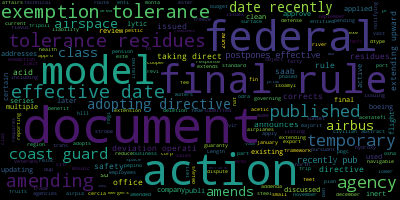

In [278]:
from IPython.display import Image
Image(filename='Rules.png')

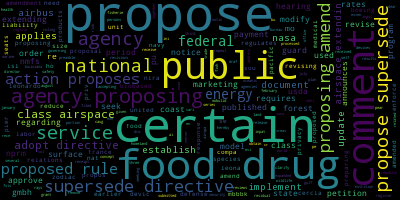

In [279]:
Image(filename='PropRules.png')

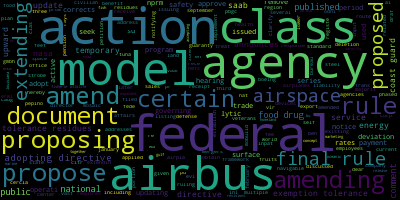

In [280]:
Image(filename='Mixed.png')